In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]

    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling

        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2

        coords.extend(ints)

        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrawidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

# Helper functions

In [3]:
def update_speed(tmp_speed_prev, tmp_action, tmp_pos_prev):
    return np.max(( np.min((tmp_speed_prev + 0.001 * tmp_action - 0.0025 * np.cos(3 * tmp_pos_prev) , 0.07)) , -0.07))

In [4]:
def update_position(tmp_pos_prev, tmp_speed):
    return np.max(( np.min(( tmp_pos_prev + tmp_speed, 0.5)) , -1.2))

In [5]:
def tiles_wrapper(tmp_pos, tmp_speed, tmp_action):
    return tiles(iht,tilings,[tilings * (tmp_pos + 1.2)/(0.5 + 1.2), tilings * (tmp_speed + 0.07)/(0.07+0.07)],[tmp_action])

In [6]:
def pick_start_position(tmp_epsilon):
    tmp_start_pos_vector = np.linspace(-0.6, -0.4, num=10, endpoint=False)
    if np.random.choice([True, False], p = (1-tmp_epsilon, tmp_epsilon)): 
            tmp_results = np.zeros((3, len(tmp_start_pos_vector)))
            for tmp_cnt in range(len(tmp_start_pos_vector)):
                tmp_results[0][tmp_cnt] = np.sum (weights_vector[tiles_wrapper( tmp_start_pos_vector[tmp_cnt], 0 ,-1)])
                tmp_results[1][tmp_cnt] = np.sum (weights_vector[tiles_wrapper( tmp_start_pos_vector[tmp_cnt], 0 ,0)])
                tmp_results[2][tmp_cnt] = np.sum (weights_vector[tiles_wrapper( tmp_start_pos_vector[tmp_cnt], 0 ,1)])
            return tmp_start_pos_vector[np.argmax(tmp_results) % len(tmp_start_pos_vector)], 0, [-1, 0, 1][np.argmax(tmp_results) // len(tmp_start_pos_vector)]
    else:
        return np.random.choice(tmp_start_pos_vector), 0, np.random.choice([-1, 0, 1])

In [7]:
def apply_fun_on_all_actions(tmp_function, tmp_pos, tmp_speed):
    return tmp_function((np.sum (weights_vector[tiles_wrapper(tmp_pos , tmp_speed ,-1)]),
        np.sum (weights_vector[tiles_wrapper(tmp_pos , tmp_speed ,0)]),
        np.sum (weights_vector[tiles_wrapper(tmp_pos , tmp_speed , 1)])))

In [8]:
def coordinates_geedy_path():
    x_list, x_dot_list, steps_to_go_list = [], [], [] 
    x, xdot, A = pick_start_position(0)
    x_list.append(x); x_dot_list.append(xdot); steps_to_go_list.append(-apply_fun_on_all_actions(np.max, x, xdot))
    #print ('x ' , x, ' xdot ',xdot)
    for cnt in range(2000):
        #print ('x ' , x, ' xdot ',xdot, ' cnt ' , cnt)
        updated_speed = update_speed(xdot, A, x)
        updated_position = update_position(x, updated_speed)
        if updated_position == -1.2:
            updated_speed = 0
        
        x_list.append(x); x_dot_list.append(xdot); steps_to_go_list.append(-apply_fun_on_all_actions(np.max, updated_position, updated_speed))
        if updated_position == 0.5:
            break
        greedy_action_next = apply_fun_on_all_actions(np.argmax, updated_position, updated_speed)
        x = updated_position
        xdot = updated_speed
        A = [-1, 0 , 1][greedy_action_next]
    return  np.array(x_list), np.array(x_dot_list),  np.array(steps_to_go_list)

In [9]:
def perform_n_step_update(tmp_n_step_list, end_of_episode_flag, n_steps):

    if len(tmp_n_step_list) >= (n_steps + 1) and not end_of_episode_flag:
        G = n_steps * -1 + np.sum(weights_vector[tmp_n_step_list[len(tmp_n_step_list)-1]])
        weights_vector[tmp_n_step_list[0]] += step_factor * (G - np.sum(weights_vector[tmp_n_step_list[0]]))
        tmp_n_step_list.pop(0)

    if end_of_episode_flag:
        if len(tmp_n_step_list) > 0:
            G = len(tmp_n_step_list) * -1
            weights_vector[tmp_n_step_list[0]] += step_factor * (G - np.sum(weights_vector[tmp_n_step_list[0]]))
            tmp_n_step_list.pop(0)
            perform_n_step_update(tmp_n_step_list, True, n_steps)
            

In [10]:
iht=IHT(4096) 
weights_vector = np.zeros(4096)
tilings = 8
step_factor = 0.1/tilings
epsilon = 0.1


**Train**

In [11]:
episode_cnt = 0
epsilon = 0#.1
step_factor =  5 * 0.1/tilings
x, xdot, A = pick_start_position(epsilon)
SA_n_step_list = []; number_of_steps = 12
SA_n_step_list.append(tiles_wrapper(x , xdot ,A))

In [12]:
while episode_cnt < 900:
    indicies_SA = tiles_wrapper(x , xdot ,A)    
    updated_speed = update_speed(xdot, A, x)
    updated_position = update_position(x, updated_speed)
    
    if updated_position == -1.2:
        updated_speed = 0 
        
    if updated_position == 0.5:
        perform_n_step_update(SA_n_step_list, True, number_of_steps)
        x, xdot, A = pick_start_position(epsilon)
        SA_n_step_list.append(tiles_wrapper(x , xdot ,A))
        episode_cnt += 1
        continue
        
    if np.random.choice([True, False], p = (1-epsilon, epsilon)):       
        greedy_action_next = apply_fun_on_all_actions(np.argmax, updated_position, updated_speed)
    else:
        greedy_action_next = np.random.choice([-1, 0 , 1])
        
    SA_n_step_list.append(tiles_wrapper(updated_position , updated_speed ,[-1, 0 , 1][greedy_action_next]))
    perform_n_step_update(SA_n_step_list, False, number_of_steps)
  
    x = updated_position
    xdot = updated_speed
    A = [-1, 0 , 1][greedy_action_next]    
    

**Plot results**

In [13]:
Xorg = np.linspace(-1.2, 0.5 ,64)
Yorg = np.linspace(-0.07, 0.07, 64)
X, Y = np.meshgrid(Yorg, Xorg)
Z = np.zeros((len(Xorg), len(Yorg)))

for rows in range(len(Xorg)):
    for cols in range(len(Yorg)):
        Z[rows][cols] = - apply_fun_on_all_actions(np.max, Xorg[rows] , Yorg[cols])

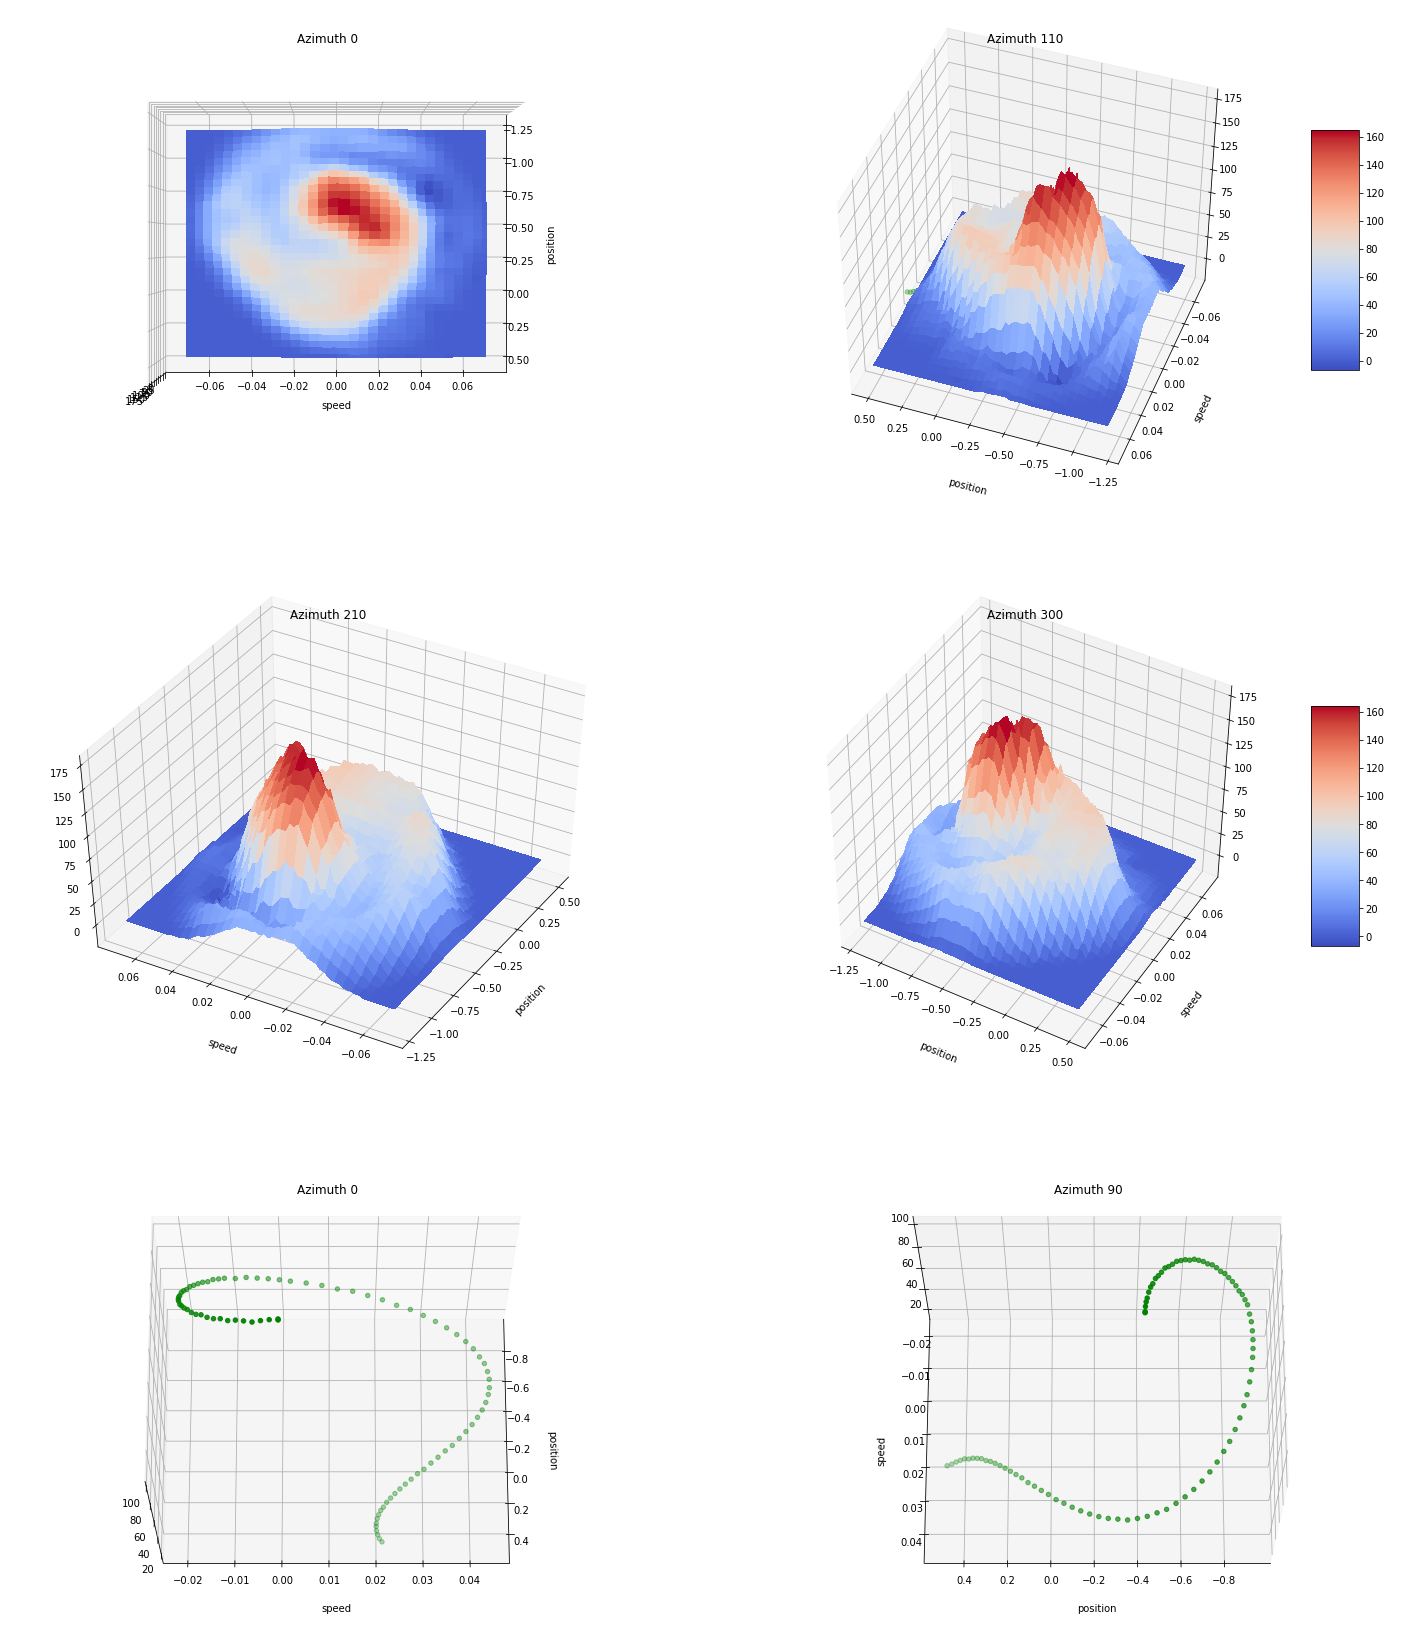

In [14]:
fig = plt.figure(figsize=(25, 30))#(figsize=plt.figaspect(1))
ax = fig.add_subplot(321, projection='3d', elev=90., azim=0)
# Set common labels

              
ax.set_title('Azimuth 0')  ; ax.set_xlabel('position', labelpad=20) ; ax.set_ylabel('speed', labelpad=20)
# Plot the surface.
surface = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
g_path_x, g_path_y, g_path_z = coordinates_geedy_path()
ax.scatter(g_path_x, g_path_y,g_path_z +15,  label='points in (x,z)' , c = 'g')
# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surface , shrink=0.5, aspect=5)

ax = fig.add_subplot(322, projection='3d', elev=45., azim=110)
ax.set_title('Azimuth 110') ; ax.set_xlabel('position', labelpad=20) ; ax.set_ylabel('speed', labelpad=20)
# Plot the surface.
surface = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.scatter(g_path_x, g_path_y, g_path_z + 20,  label='points in (x,z)', c = 'g')
fig.colorbar(surface , shrink=0.5, aspect=5)


ax = fig.add_subplot(323, projection='3d', elev=45., azim=210)
ax.set_title('Azimuth 210'); ax.set_xlabel('position', labelpad=20) ; ax.set_ylabel('speed', labelpad=20)
# Plot the surface.
surface = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.scatter(g_path_x, g_path_y, g_path_z + 25,  label='points in (x,z)', c = 'g')
#fig.colorbar(surface , shrink=0.5, aspect=5)

ax = fig.add_subplot(324, projection='3d', elev=45., azim=300)
ax.set_title('Azimuth 300'); ax.set_xlabel('position', labelpad=20) ; ax.set_ylabel('speed', labelpad=20)
# Plot the surface.
surface = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.scatter(g_path_x, g_path_y, g_path_z + 15 ,  label='points in (x,z)', c = 'g')
fig.colorbar(surface , shrink=0.5, aspect=5)


ax = fig.add_subplot(325, projection='3d', elev=70., azim=0)
ax.set_title('Azimuth 0'); ax.set_xlabel('position', labelpad=20) ; ax.set_ylabel('speed', labelpad=20)
ax.scatter(g_path_x, g_path_y, g_path_z + 15 ,  label='points in (x,z)', c = 'g')


ax = fig.add_subplot(326, projection='3d', elev=70., azim=90)
ax.set_title('Azimuth 90'); ax.set_xlabel('position', labelpad=20) ; ax.set_ylabel('speed', labelpad=20)
ax.scatter(g_path_x, g_path_y, g_path_z + 15 ,  label='points in (x,z)', c = 'g')